# Neural networks for images

* Introduction
    * Visualisations of dataset
* Multi-layer perceptron
* Convolutional neural network
    * Prediction uncertainties
* Recurrent neural network
* Generative adverserial network
    * Conditional Generative adversarial network

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns

import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1 Introduction

## 1.1 MNIST dataset

The MNIST dataset consists of 70000 images of handwritten digits, 60000 used for training and 10000 for testing. The dataset is simple and very useful for benchmarking and experimenting with various classifiers. Due to the relatively small size of this dataset, the training times of models with larger numbers of parameters on this dataset with limited hardware are reasonable, making this dataset a suitable choice to experiment with.

The following cells show the loading and visualisations of the dataset.

In [3]:
# With the MNIST dataset downloaded and stored in the folder 'data',
# the files are loaded and saved to disk as 'pkl' files for fast access
from mnist import load_and_pickle, load_from_pickle

#mnist_dir = './data/'
mnist_dir = '/content/drive/MyDrive/neural_networks_images/data/'

if 'mnist.pkl' not in os.listdir(mnist_dir):
    load_and_pickle(mnist_dir)
data = load_from_pickle(mnist_dir + 'mnist.pkl')

Xtrain, ytrain = data['Xtrain'] / 255, data['ytrain']
Xtest, ytest = data['Xtest'] / 255, data['ytest']

In [4]:
# Viewing the sizes of the training and test sets
print('Size of training images:', Xtrain.shape)
print('Size of training labels:', ytrain.shape)

print('Size of test images:', Xtest.shape)
print('Size of test labels:', ytest.shape)

Size of training images: (60000, 28, 28)
Size of training labels: (60000,)
Size of test images: (10000, 28, 28)
Size of test labels: (10000,)


### Visualisations of dataset

Dimensionality reduction techniques offer ways for datasets to be visualised. Principal component analysis (PCA) is a common and standard algorithm to perform dimensionality reduction. PCA is useful because the data is projected on axes along which the variances of the data are greatest. In this sense, PCA offers also a way to perform feature selection where (i) features which are largely constant across the training set can be determined and ignored, and (ii) any correlations between features are eliminated when performing dimensionality reduction with PCA.

For visualising the MNIST dataset, PCA was used to project the data onto the axes capturing the greatest variabilities of the data. The projection of the training set onto the first two and three principal components was performed and the resulting visualisations shown.

Shape of training set with reduced dimensions: (60000, 2)


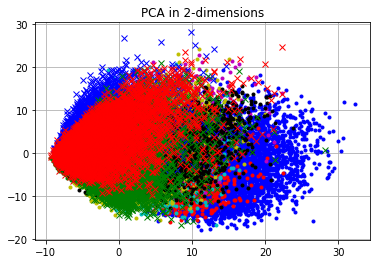

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Dimensionality reduction of training set
Xtrain_2d = PCA(n_components=2)\
            .fit_transform(StandardScaler().fit_transform(Xtrain.reshape(Xtrain.shape[0], -1)))
print('Shape of training set with reduced dimensions:', Xtrain_2d.shape)

# 2-D visualisation of training set
plt.figure()
ax = plt.axes()
pt_ = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.', 'bx', 'gx', 'rx']
for c in range(10):
    idx = np.nonzero(ytrain == c)
    ax.plot(Xtrain_2d[idx, 0], Xtrain_2d[idx, 1], pt_[c])
plt.title('PCA in 2-dimensions')
plt.grid(True)
plt.show()

Shape of training set with reduced dimensions: (60000, 3)


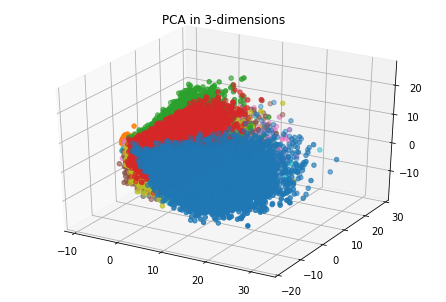

In [ ]:
# Dimensionality reduction of training set
Xtrain_3d = PCA(n_components=3)\
            .fit_transform(StandardScaler().fit_transform(Xtrain.reshape(Xtrain.shape[0], -1)))
print('Shape of training set with reduced dimensions:', Xtrain_3d.shape)

# 3-D visualisation of training set
fig = plt.figure()
ax = Axes3D(fig)
pt_ = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.', 'bx', 'gx', 'rx']
for c in range(10):
    idx = np.nonzero(ytrain == c)
    ax.scatter(Xtrain_3d[idx, 0], Xtrain_3d[idx, 1], Xtrain_3d[idx, 2], pt_[c])
plt.title('PCA in 3-dimensions')
plt.grid(True)
plt.show()

Visualisations of dataset can sometimes help determine if the dataset is sufficiently discriminative for classification. The above visualisations show that data points belonging to a particular class are largely clustered together. Although overlaps between data points of different classes are observed, the discrimination between different classes is not expected to be lost when higher dimensions are considered.

Visualisations with PCA show only the data points along the axes of greatest variabilities. More useful visualisations can be made with tSNE, a non-linear dimensionality reduction technique commonly used in deep learning. Unlike PCA, tSNE preserves the relative distances between neighbouring data points when projecting to lower dimensions. A visualisation of the reduced training set using tSNE is shown below. Clear clusters formed by data points belonging to a particular class were observed, although some outliers were also seen far from the cluster centroids. This thus suggest that the given dataset is sufficiently discriminative.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.078s...
[t-SNE] Computed neighbors for 1000 samples in 8.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.729028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.692184
[t-SNE] Error after 1000 iterations: 1.064781


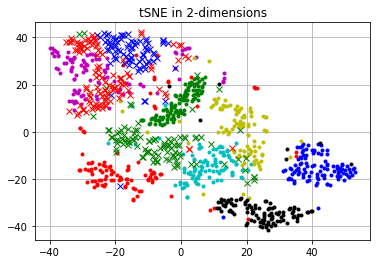

In [ ]:
from sklearn.manifold import TSNE

# Randomly select 1000 training data points
rand_idx = np.random.choice(60000, size=1000)
Xtrain_sample = Xtrain.reshape(Xtrain.shape[0], -1)[rand_idx, :]
ytrain_sample = ytrain[rand_idx]

# Dimensionality reduction of training set
Xtrain_2d = TSNE(n_components=2, init='pca', verbose=1).fit_transform(Xtrain_sample)

# 2-D visualisation of reduced training set
plt.figure()
ax = plt.axes()
pt_ = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.', 'bx', 'gx', 'rx']
for c in range(10):
    idx = np.nonzero(ytrain_sample == c)
    ax.plot(Xtrain_2d[idx, 0], Xtrain_2d[idx, 1], pt_[c])
plt.title('tSNE in 2-dimensions')
plt.grid(True)
plt.show()

# 2 Multi-layer perceptron

It is useful to first check the classification of the dataset with a multi-layer perceptron. A two-layer perceptron with 1028 hidden layer neurons was implemented to classify the MNIST dataset. The training of the neural network and the classification accuracies of the trained network on the training and test sets are shown below.

In [ ]:
Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, -1).to(device)
ytrain = torch.from_numpy(ytrain).long().to(device)
Xtest = (torch.from_numpy(Xtest).float()).reshape(10000, -1).to(device)
ytest = torch.from_numpy(ytest).long().to(device)

In [ ]:
from classifiers import MultiLayerPerceptron

net = MultiLayerPerceptron(num_hidden_neurons=[1028], 
                           batch_norm=False, 
                           dropout_proba=None).to(device)

train_stats = net.fit(Xtrain, ytrain, verbose=True)

Loss after epoch 1: 0.10731732100248337
Loss after epoch 2: 0.04173446074128151
Loss after epoch 3: 0.08681480586528778
Loss after epoch 4: 0.06765208393335342
Loss after epoch 5: 0.013882406055927277
Loss after epoch 6: 0.08601953834295273
Loss after epoch 7: 0.0071243238635361195
Loss after epoch 8: 0.02345212735235691
Loss after epoch 9: 0.06432367116212845
Loss after epoch 10: 0.0013590711168944836


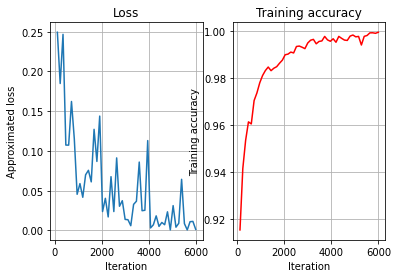

In [ ]:
# Plot training statistics
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_stats['ite'], train_stats['loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Approximated loss')
ax1.grid(True)

ax2.plot(train_stats['ite'], train_stats['train_acc'], 'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Training accuracy')
ax2.grid(True)
plt.show()

In [ ]:
# Accuracy on test set
ypred = net.predict(Xtest)
print('Test accuracy:', ((ypred == ytest).sum() / len(ytest)).item())

Test accuracy: 0.9824000000953674


As demonstrated, the trained networks were able to accurately classify at least $98 \%$ of the test set. The test accuracy is also generally higher with increased number of hidden layer neurons since networks with larger number of hidden layer neurons are able to map more complex decision boundaries and overfit to the training and test sets.

# 3 Convolutional neural network

As shown above, a two-layer perceptron can give reasonable classification performances on the given dataset. However, the use of MLPs alone are not preferred in more general image classification problems. There are at least three rationales for the use of deep learning techniques over conventional machine learning classifiers that can be immediately listed:
1. Conventional machine learning classifiers, including MLPs, fail quickly when input images contain more than one channel;
2. Spatial structure of input images, which may be important for improved performances, are not preserved by many conventional machine learning classifiers including MLPs;
3. Performances of conventional machine learning classifiers do not scale with increased training data.

The below shows the training of an implemented CNN on the MNIST dataset. After 10 training epochs, the CNN was able to accurately classify up to $99 \%$ of the test set.

In [ ]:
Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 1, 28, 28).to(device)
ytrain = torch.from_numpy(ytrain).long().to(device)
Xtest = (torch.from_numpy(Xtest).float()).reshape(10000, 1, 28, 28).to(device)
ytest = torch.from_numpy(ytest).long().to(device)

In [ ]:
from classifiers import CNN

net = CNN().to(device)
train_stats = net.fit(Xtrain, ytrain)

Loss after epoch 1: 0.13921478390693665
Loss after epoch 2: 0.04063349589705467
Loss after epoch 3: 0.04817735776305199
Loss after epoch 4: 0.01960599608719349
Loss after epoch 5: 0.026216695085167885
Loss after epoch 6: 0.07198489457368851
Loss after epoch 7: 0.050153590738773346
Loss after epoch 8: 0.17132093012332916
Loss after epoch 9: 0.0031916946172714233
Loss after epoch 10: 0.004050181247293949


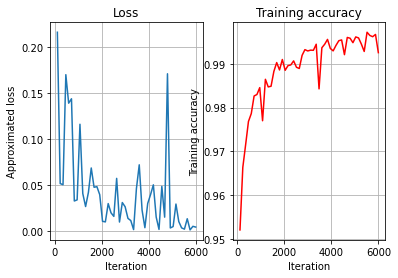

In [ ]:
# Plot training statistics
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_stats['ite'], train_stats['loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Approximated loss')
ax1.grid(True)

ax2.plot(train_stats['ite'], train_stats['train_acc'], 'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Training accuracy')
ax2.grid(True)
plt.show()

In [ ]:
# Accuracy on test set
ypred = net.predict(Xtest)
print('Test accuracy:', ((ypred == ytest).sum() / len(ytest)).item())

Test accuracy: 0.9875999689102173


## 3.1 Visualisations of network layers

### 3.1.1 Final fully-connected layer

To visualise the fitted final fully-connected layer, features of test images as implied from this layer may be considered. For every test image, an associated 100-dimensional feature vector may be obtained by passing that test image through the fitted network up till the final fully-connected layer.

In [ ]:
# For each test image, there is an associated feature vector of dimension 100
feature_vector = net.fc_layers[0](net.conv_layers2(net.conv_layers1(Xtest))\
                                  .view(Xtest.shape[0], -1))\
                 .cpu().detach().numpy()

**Test images nearest in feature space**

With these associated feature vectors, one can then visualise test images that are nearest to each other in feature space.

One random test image from each class was selected, and the test images nearest in feature space to this test image found. The below plots these selected test images (first column) and their four nearest test images.

In [ ]:
from scipy.spatial import distance

# Selecting random test images for each class
idx = [np.random.choice(np.where(ytest.cpu()==c)[0]) for c in range(10)]

# For each randomly selected test image, indices of test images nearest in feature space
dist = distance.cdist(feature_vector[idx], feature_vector)
idx_nearest = np.argsort(dist, axis=1)[:, 0:5]

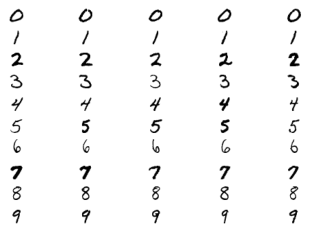

In [ ]:
plt.figure()
gs = gridspec.GridSpec(idx_nearest.shape[0], idx_nearest.shape[1])

for i, idx_img in enumerate(idx_nearest.flatten()):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(Xtest[idx_img].reshape(28, 28).cpu().detach().numpy(), cmap='gray_r')

**Discrimination of feature vector**

These feature vectors can also be visualised by reducing their dimensions down to two. The below does this using tSNE. It was observed the presence of clear clusters containing feature vectors belonging lagely to homogeneous classes. The feature vectors at the final fully-connected layer are thus very much discriminative, allowing the network to provide very accurate classifications.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 11.824129
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.873489
[t-SNE] KL divergence after 1000 iterations: 0.496545


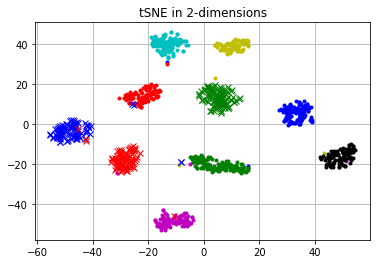

In [ ]:
from sklearn.manifold import TSNE

# Randomly select 1000 feature vectors
rand_idx = np.random.choice(10000, size=1000)
feature_vector_sample = feature_vector[rand_idx, :]
class_label_sample = ytest.cpu().detach().numpy()[rand_idx]

# Dimensionality reduction of selected feature vectors
feature_vector_2d = TSNE(n_components=2, init='pca', verbose=1)\
                    .fit_transform(feature_vector_sample)

# 2-D visualisation of selected feature vectors
plt.figure()
ax = plt.axes()
pt_ = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.', 'bx', 'gx', 'rx']
for c in range(10):
    idx = np.nonzero(class_label_sample == c)
    ax.plot(feature_vector_2d[idx, 0], feature_vector_2d[idx, 1], pt_[c])
plt.title('tSNE in 2-dimensions')
plt.grid(True)
plt.show()

## 3.2 Prediction uncertainties

In many applications, it is useful to obtain a measure of confidence on the predicted labels of test examples. Networks, in the usual sense, assign a predicted class label to each test example based on the output softmax probabilities. These probabilities however do not necessarily represent the confidence of the network on the predictions.

For networks containing dropout layers, prediction uncertainties that quantify the confidence of predictions are easily obtained via MC-Dropout technique. 

### 3.2.1 Demonstration of technique

This described technique is checked on a contrived dataset consisting of points uniformly sampled on the unit circle. Points in the lower right quadrant of the circle were discarded, and class labels were assigned based on the distance of each example from the origin.

An MLP containing dropout layers was fitted to this training set, and the MC-Dropout technique used to obtain predictions of the test set and their uncertainties.

As observed in the last plot of this section, based on the mapped decision boundary, predictions are most uncertain for test examples located near the decision boundary and in regions where training examples were never seen.

In [ ]:
from classifiers import MultiLayerPerceptron
from sklearn.preprocessing import StandardScaler

In [ ]:
num_class1 = 600
num_class0 = 600

def generate_point(num_samples, r_lower=0, r_upper=1):
    r = np.sqrt((r_upper**2 - r_lower**2) * np.random.random(num_samples) + r_lower**2)    
    theta = 2*np.pi * np.random.random(num_samples)
    
    return np.c_[r*np.cos(theta), r*np.sin(theta)]

Xtrain_circle = np.r_[generate_point(num_class0, 0, 0.45), generate_point(num_class1, 0.55, 1)]
Xtrain_circle = Xtrain_circle[~((Xtrain_circle[:, 0] > 0) & (Xtrain_circle[:, 1] < 0))]
ytrain_circle = (np.sqrt(np.sum(Xtrain_circle**2, axis=1)) >= 0.5).astype(int)

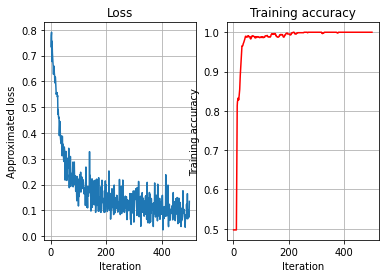

In [ ]:
scaler = StandardScaler()

net = MultiLayerPerceptron(input_dim=2, num_classes=2, 
                           num_hidden_neurons=[10, 10], 
                           batch_norm=False, dropout_proba=0.25).to(device)

train_stats = net.fit(torch.from_numpy(scaler.fit_transform(Xtrain_circle)).float().to(device), 
                      torch.from_numpy(ytrain_circle).long().to(device),
                      learning_rate=0.01, 
                      num_epochs=100, batch_size=200, 
                      verbose=False)

# Plot training statistics
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_stats['ite'], train_stats['loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Approximated loss')
ax1.grid(True)

ax2.plot(train_stats['ite'], train_stats['train_acc'], 'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Training accuracy')
ax2.grid(True)
plt.show()

In [ ]:
x_num_points, x_min, x_max = 100, -1, 1
y_num_points, y_min, y_max = 100, -1, 1

x0, x1 = np.meshgrid(np.linspace(x_min, x_max, x_num_points), 
                     np.linspace(y_min, y_max, y_num_points))
Xtest_grid = np.c_[x0.flatten(), x1.flatten()]

In [ ]:
ypred, pred_vars = net.predict(torch.from_numpy(scaler.transform(Xtest_grid)).float().to(device), 
                               MC_dropout=True)

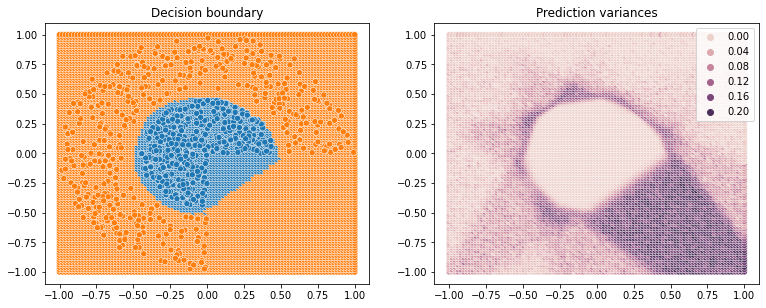

In [ ]:
plt.figure(figsize=(2*6.4, 4.8))
plt.subplot(121)
sns.scatterplot(x=Xtest_grid[:, 0], y=Xtest_grid[:, 1], hue=ypred.cpu(), s=40, legend=False)
sns.scatterplot(x=Xtrain_circle[:, 0], y=Xtrain_circle[:, 1], hue=ytrain_circle, legend=False)
plt.title('Decision boundary')

plt.subplot(122)
sns.scatterplot(x=Xtest_grid[:, 0], y=Xtest_grid[:, 1], hue=pred_vars.cpu())
plt.title('Prediction variances')

plt.show()

# 4 Recurrent neural network

Recurrent neural networks (RNNs) are used usually on sequential data. To use RNNs on the MNIST dataset, the images of dimensions $28\times28$ can be viewed as 28-dimensional data vectors containing 28 time-steps.

It is shown below the training of a RNN on the MNIST dataset. The RNN was made to have the LSTM architecture to enable learning of long-term dependencies. Although it was expected the architectures of RNNs may not adequately capture the structure of the data, interestingly the RNN was still able to accurately classify up to $95\%$ of the test set.

In [ ]:
Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 28, 28).to(device)
ytrain = torch.from_numpy(ytrain).long().to(device)
Xtest = (torch.from_numpy(Xtest).float()).reshape(10000, 28, 28).to(device)
ytest = torch.from_numpy(ytest).long().to(device)

In [ ]:
from classifiers import LSTM

rnn = LSTM().to(device)
train_stats = rnn.fit(Xtrain, ytrain, num_epochs=5)

Loss after epoch 1: 0.2972060441970825
Loss after epoch 2: 0.09196227788925171
Loss after epoch 3: 0.11245479434728622
Loss after epoch 4: 0.08705725520849228
Loss after epoch 5: 0.09731986373662949


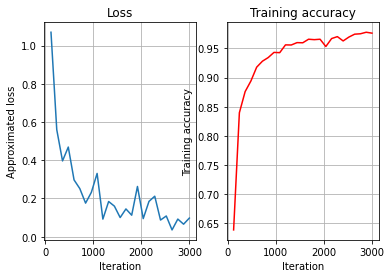

In [ ]:
# Plot training statistics
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_stats['ite'], train_stats['loss'])
ax1.set_title('Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Approximated loss')
ax1.grid(True)

ax2.plot(train_stats['ite'], train_stats['train_acc'], 'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Training accuracy')
ax2.grid(True)
plt.show()

In [ ]:
# Accuracy on test set
ypred = rnn.predict(Xtest)
print('Test accuracy:', ((ypred == ytest).sum() / len(ytest)).item())

Test accuracy: 0.9681999683380127


# 5 Generative adversarial networks

Neural networks can be made to generate outputs that are similar to the training set by jointly training two neural networks in a minimax fashion. GANs consist of a generator network generating images from random noise, and a discriminator network discriminating between real images from the training set and fake images generated by the generator network. The training of the networks involves updating parameters of the generator network such that generated images are not distinguished by the discriminator network. Similarly, the parameters of the discriminator network are updated such that real and fake images can be distinguished.

A GAN was implemented to sample from the MNIST dataset. For reasonable training times, the generator and discriminator networks were made to consist only of fully-connected layers. Images generated by the generator network from noise inputs are shown for after every training epoch. The generator network trained for 10 epochs was able to generate images that reasonably resemble images from the training set.

In [5]:
Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 1, 28, 28).to(device)

Generated images after epoch 1


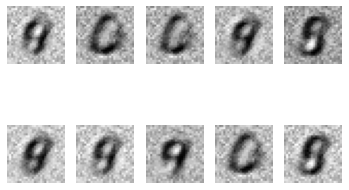

Generated images after epoch 2


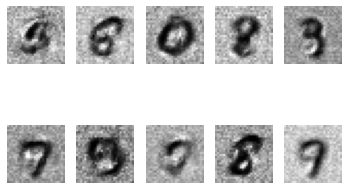

Generated images after epoch 3


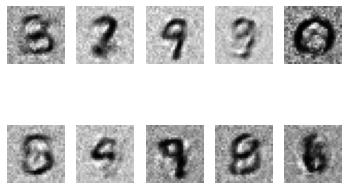

Generated images after epoch 4


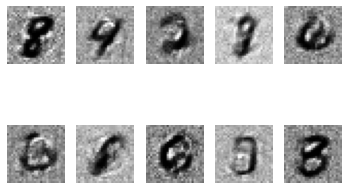

Generated images after epoch 5


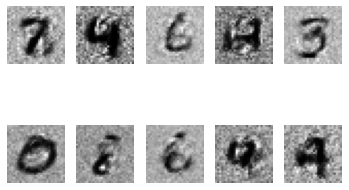

Generated images after epoch 6


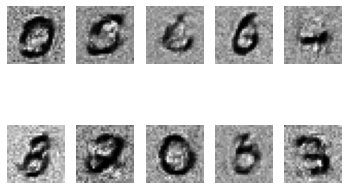

Generated images after epoch 7


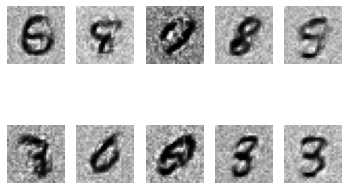

Generated images after epoch 8


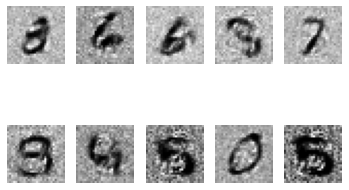

Generated images after epoch 9


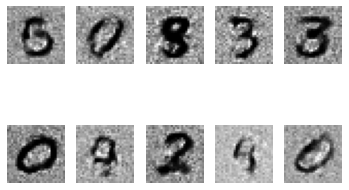

Generated images after epoch 10


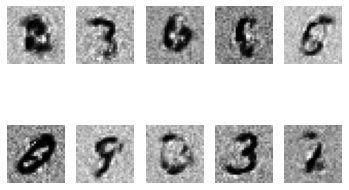

In [6]:
from gan import GAN

gan = GAN(device=device)

train_stats = gan.fit(Xtrain)

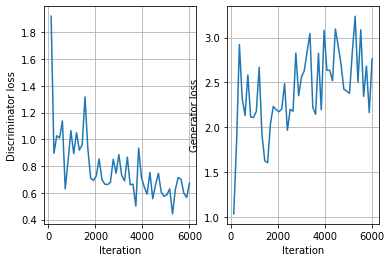

In [7]:
# Plotting training history        
plt.subplot(1,2,1)
plt.plot(train_stats['ite'], train_stats['discriminator_loss'])
plt.xlabel('Iteration')
plt.ylabel('Discriminator loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_stats['ite'], train_stats['generator_loss'])
plt.xlabel('Iteration')
plt.ylabel('Generator loss')
plt.grid(True)
plt.show()

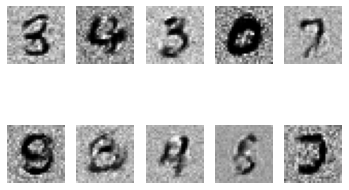

In [8]:
# Display images generated from trained generator network
N = 10

images = gan.predict(N)
gan.display_images(images)

## 5.1 Conditional Generative Adversarial Networks

The implemented network above was only able to generate images out of noise input, without any additional control over the kind of images generated. An additional modification may be made to the the above such that images of some selected class may be generated.

This was done by incorporating placeholders for label information in the structure of the model and then training labels into the training of the network.

A c-GAN with the same architecture as the above was trained. After 10 training epochs, the generator network was able to generate images that reasonably resemble training images from each of the 10 classes.

In [5]:
Xtrain = (torch.from_numpy(Xtrain).float()).reshape(60000, 1, 28, 28).to(device)
# One-hot encoding
y = torch.zeros(60000, 10).to(device)
y[range(60000), torch.from_numpy(ytrain).long()] = 1

Generated images after epoch 1


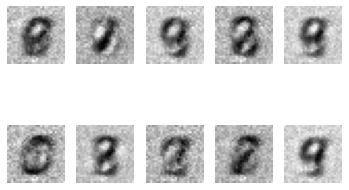

Generated images after epoch 2


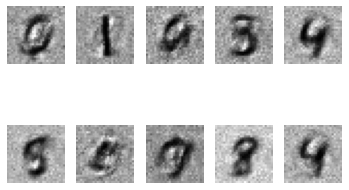

Generated images after epoch 3


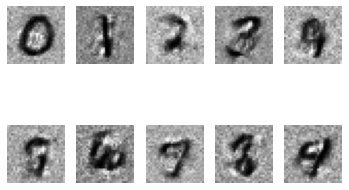

Generated images after epoch 4


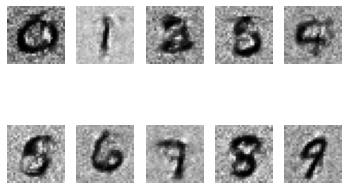

Generated images after epoch 5


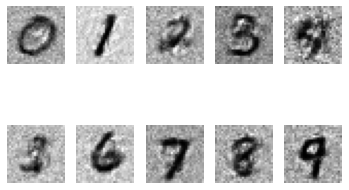

Generated images after epoch 6


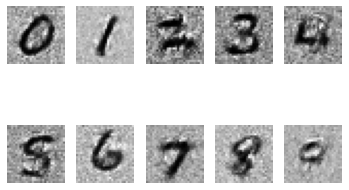

Generated images after epoch 7


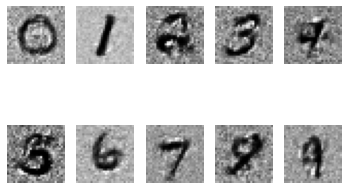

Generated images after epoch 8


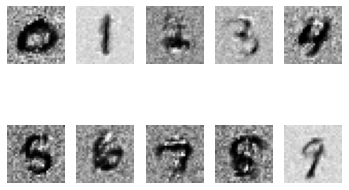

Generated images after epoch 9


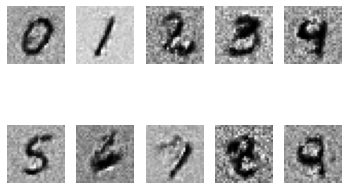

Generated images after epoch 10


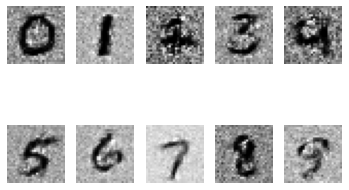

In [6]:
from gan import GAN

c_gan = GAN(with_labels=True, device=device)

train_stats = c_gan.fit(Xtrain, y)

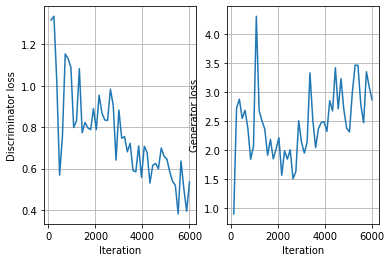

In [7]:
# Plotting training history        
plt.subplot(1,2,1)
plt.plot(train_stats['ite'], train_stats['discriminator_loss'])
plt.xlabel('Iteration')
plt.ylabel('Discriminator loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_stats['ite'], train_stats['generator_loss'])
plt.xlabel('Iteration')
plt.ylabel('Generator loss')
plt.grid(True)
plt.show()

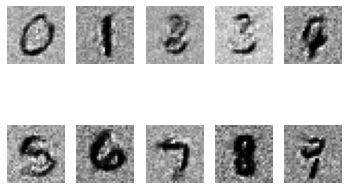

In [8]:
# Display images generated from trained generator network
N = 10

labels = torch.zeros((N, 10)).to(device)
labels[range(10), range(10)] = 1

images = c_gan.predict(N, labels)
c_gan.display_images(images)